#Task 1

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data directly from UCI HAR repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

# Unzip and read files (already preprocessed features)
import zipfile, requests, io
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Load the original feature names
features = pd.read_csv(z.open('UCI HAR Dataset/features.txt'),
                       delim_whitespace=True, header=None, names=['index', 'feature'])

# Make feature names unique
def make_unique(column_names):
    seen = {}
    unique_names = []
    for name in column_names:
        if name not in seen:
            seen[name] = 0
            unique_names.append(name)
        else:
            seen[name] += 1
            unique_names.append(f"{name}_{seen[name]}")
    return unique_names

# Apply cleaning and deduplication
clean_feature_names = make_unique(
    [name.replace('(', '').replace(')', '').replace('-', '_').replace(',', '_') for name in features['feature']]
)


# Read feature names
features = pd.read_csv(z.open('UCI HAR Dataset/features.txt'),
                       delim_whitespace=True, header=None, names=['index', 'feature'])
feature_names = features['feature'].values

# Load datasets
X_train = pd.read_csv(z.open('UCI HAR Dataset/train/X_train.txt'),
                      delim_whitespace=True, header=None, names=clean_feature_names)

X_test = pd.read_csv(z.open('UCI HAR Dataset/test/X_test.txt'),
                     delim_whitespace=True, header=None, names=clean_feature_names)

y_train = pd.read_csv(z.open('UCI HAR Dataset/train/y_train.txt'), header=None)[0]

y_test = pd.read_csv(z.open('UCI HAR Dataset/test/y_test.txt'), header=None)[0]


<ipython-input-31-d70912ff97e2>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(z.open('UCI HAR Dataset/features.txt'),
<ipython-input-31-d70912ff97e2>:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv(z.open('UCI HAR Dataset/features.txt'),
<ipython-input-31-d70912ff97e2>:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(z.open('UCI HAR Dataset/train/X_train.txt'),
<ipython-input-31-d70912ff97e2>:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(z.open('UCI HAR Dataset/test/X_test.txt'),


Train & Tune Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)


Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.97      0.94       496
           2       0.89      0.92      0.90       471
           3       0.96      0.85      0.90       420
           4       0.91      0.89      0.90       491
           5       0.90      0.92      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



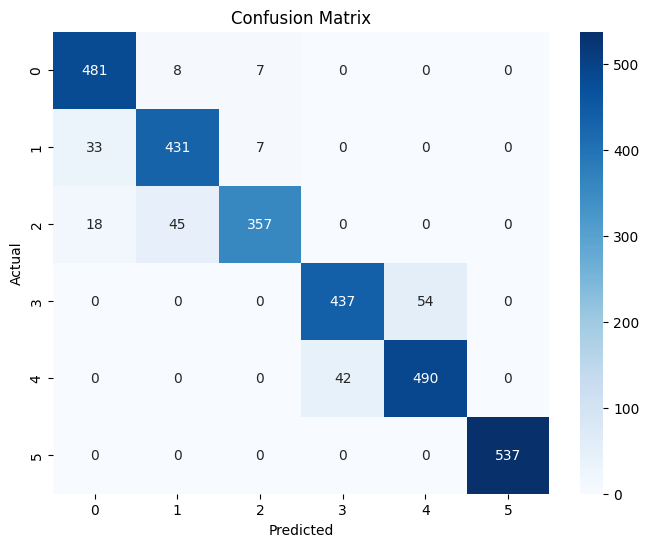

In [ ]:
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Cross Validation Score

In [ ]:
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1 Score:", cv_scores.mean())

Cross-validation F1 scores: [0.91011242 0.89957628 0.90630357 0.92238015 0.95610194]
Mean CV F1 Score: 0.9188948740750208


Feature Importance

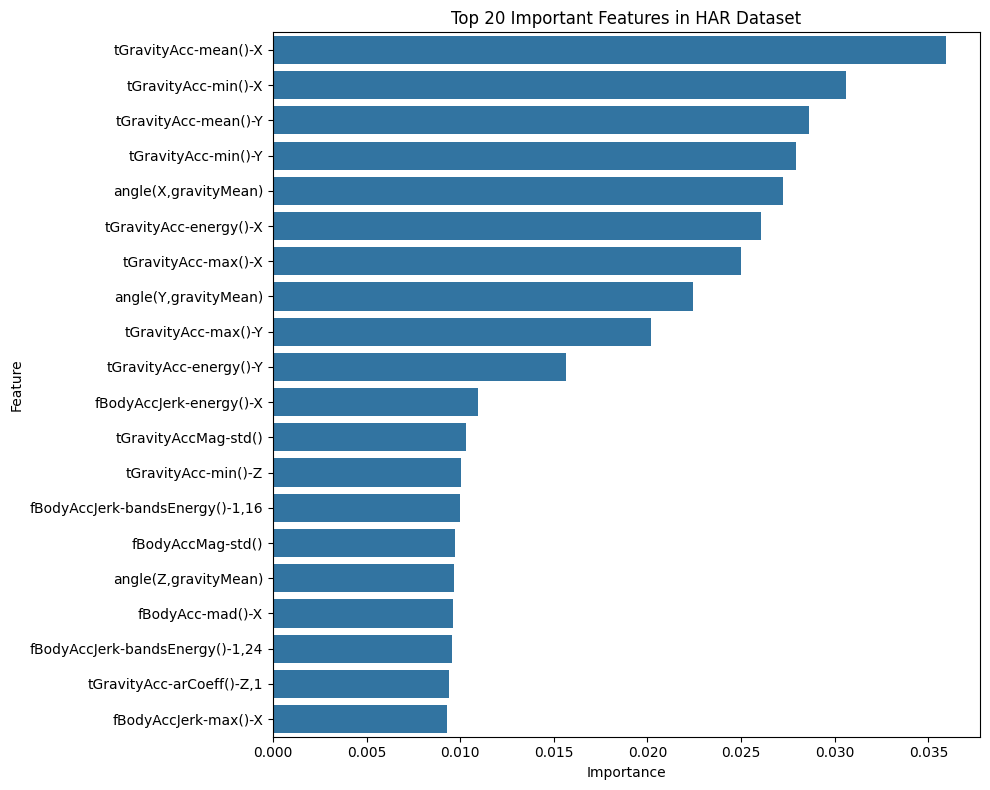

In [ ]:
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Important Features in HAR Dataset")
plt.tight_layout()
plt.show()

#Task 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
heart_disease = pd.read_csv('/content/heart_2020_cleaned.csv')

In [ ]:
heart_disease.head()

In [ ]:
categorical_columns = [
    'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
    'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
    'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'
]

# Initialize label encoders for each categorical column
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    heart_disease[column] = label_encoders[column].fit_transform(heart_disease[column])

# Display the first few rows of the transformed dataset
print("Transformed Dataset (First 5 Rows):")
print(heart_disease.head())

# Save the transformed dataset to a new CSV file
heart_disease.to_csv('heart_2020_cleaned_encoded.csv', index=False)

In [ ]:
 heart_disease.shape

In [ ]:
features = heart_disease.drop(columns = 'HeartDisease', axis = 1)
target = heart_disease['HeartDisease']
print(features)
print(target)

In [ ]:
heart_disease.value_counts('Race')

American Indian/Alaskan Native = 0

Asian = 1

Black = 2

Hispanic = 3

Other = 4

White = 5

In [ ]:
heart_disease.value_counts('AgeCategory')

18-24 = 0

25-29 = 1

30-34 = 2

35-39 = 3

40-44 = 4

45-49 = 5

50-54 = 6

55-59 = 7

60-64 = 8

65-69 = 9

70-74 = 10

75-79 = 11

80 or older = 12

In [ ]:
heart_disease.value_counts('GenHealth')

Poor = 0

Fair = 1

Good = 2

Very good = 3

Excellent = 4

In [ ]:
heart_disease.value_counts('Diabetic')

No = 0

Yes = 1

"No, borderline diabetes" = 2

Yes (during pregnancy) = 3

Every other categorical variable is of the form

0 -> No

1 -> Yes

**Data Standardization**

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
standardized_data = scaler.transform(features)
print(standardized_data)
features = standardized_data
target = heart_disease['HeartDisease']

**Train Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 7)
print(features.shape, x_train.shape, x_test.shape)

In [ ]:
if isinstance(x_train, pd.DataFrame):
    # Drop rows with NaNs in x_train and corresponding y_train
    mask = ~x_train.isna().any(axis=1)
    x_train_clean = x_train[mask]
    y_train_clean = y_train[mask]

    # Drop rows with NaNs in x_test
    x_test_clean = x_test.dropna()
else:
    # For numpy arrays
    mask = ~np.isnan(x_train).any(axis=1)
    x_train_clean = x_train[mask]
    y_train_clean = y_train[mask]

    mask_test = ~np.isnan(x_test).any(axis=1)
    x_test_clean = x_test[mask_test]
    y_test_clean = y_test[mask_test]

# Ensure no NaNs remain
if np.any(np.isnan(x_train_clean)) or np.any(np.isnan(x_test_clean)):
    raise ValueError("NaNs remain in the data after cleaning.")

kernels = ['linear', 'rbf']
models = {}
for kernel in kernels:
    model = SVC(kernel=kernel, probability=True, random_state=12)
    model.fit(x_train_clean, y_train_clean)
    models[kernel] = model
    y_pred = model.predict(x_test_clean)

    # Evaluate the model
    accuracy = accuracy_score(y_test_clean, y_pred)
    precision = precision_score(y_test_clean, y_pred)
    recall = recall_score(y_test_clean, y_pred)
    auc = roc_auc_score(y_test_clean, model.predict_proba(x_test_clean)[:, 1])

    print(f"\nSVM with {kernel} kernel:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")

#Task 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.math import confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Shape of numpy arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


This means that the dataset has 60,000 training images and 10,000 test images

Dimension of Image =  28 x 28

Grayscale Image = 1 Channel

In [ ]:
print(x_train[70])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  64 191  70   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  68 243 253 249  63   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30 223 253 253 247  41   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  73 238 253 253 253 242   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  73 236 253 253 253 253 242   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 182 253 253 191 247 253 14

In [ ]:
print(x_train[70].shape)

(28, 28)


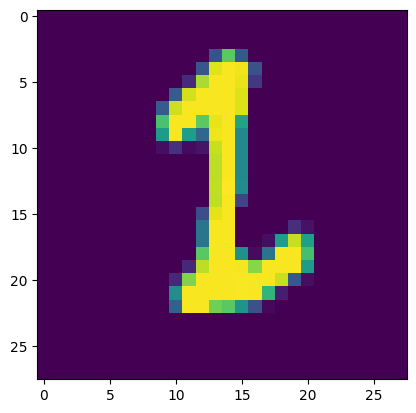

Corresponding Y-label : 1


In [ ]:
#Displaying the img
plt.imshow(x_train[70])
plt.show()

#Print the corresponding label
print("Corresponding Y-label :", y_train[70])

In [ ]:
# Unique values in y train
print(np.unique(y_train))

# Unique values in y test
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Scaling the values
x_train = x_train/255
x_test =  x_test/255

In [ ]:
# Printing the 70th value after standardizing
print(x_train[70])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.2509

In [ ]:
# Setting up the layers of the Neural Network
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(28,28)),
                          keras.layers.Dense(50, activation='relu'),
                          keras.layers.Dense(50, activation= 'relu'),
                          keras.layers.Dense(10, activation = 'sigmoid')
])

# Compiling the Neural Network
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training the neural network
model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8395 - loss: 0.5363
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9574 - loss: 0.1420
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9688 - loss: 0.1050
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9753 - loss: 0.0833
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9801 - loss: 0.0682
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9834 - loss: 0.0571
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9856 - loss: 0.0485
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9879 - loss: 0.0410
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9890 - loss: 0.0352
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9905 - loss: 0.0316


Training Acc = 99.05%

In [ ]:
loss , accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9678 - loss: 0.1382
Test Accuracy: 0.972000002861023


Test Accuracy = 97.2%

This shows that our model is not overfitting

In [ ]:
print(x_test.shape)

(10000, 28, 28)


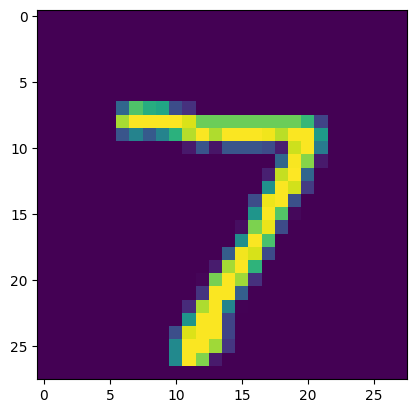

In [ ]:
# First data pt in x_test
plt.imshow(x_test[0])
plt.show()

In [ ]:
print(y_test[0])

7


In [ ]:
y_pred = model.predict(x_test)
print(y_pred.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)


In [ ]:
print(y_pred[0])

[1.0088699e-01 1.9473889e-03 4.7173092e-01 3.8548031e-01 3.1530087e-07
 9.6186952e-05 5.0852602e-16 9.9999934e-01 5.9759356e-03 7.2808880e-01]


model.predict() give the probability of each class for that data point

In [ ]:
# Converting the prediction probabilities to class label
label_for_first_img = np.argmax(y_pred[0])
print(label_for_first_img)

7


In [ ]:
# Converting the prediction probabilities to class label for all the data points
y_pred_labels = [np.argmax(i) for i in y_pred]
print(y_pred_labels)

[np.int64(7), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(1), np.int64(4), np.int64(9), np.int64(5), np.int64(9), np.int64(0), np.int64(6), np.int64(9), np.int64(0), np.int64(1), np.int64(5), np.int64(9), np.int64(7), np.int64(3), np.int64(4), np.int64(9), np.int64(6), np.int64(6), np.int64(5), np.int64(4), np.int64(0), np.int64(7), np.int64(4), np.int64(0), np.int64(1), np.int64(3), np.int64(1), np.int64(3), np.int64(4), np.int64(7), np.int64(2), np.int64(7), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(7), np.int64(4), np.int64(2), np.int64(3), np.int64(5), np.int64(1), np.int64(2), np.int64(4), np.int64(4), np.int64(6), np.int64(3), np.int64(5), np.int64(5), np.int64(6), np.int64(0), np.int64(4), np.int64(1), np.int64(9), np.int64(5), np.int64(7), np.int64(8), np.int64(8), np.int64(3), np.int64(7), np.int64(4), np.int64(6), np.int64(4), np.int64(3), np.int64(0), np.int64(7), np.int64(0), np.int64(2), np.int64(9), np.int64(1), np.int64(7), np.int64(3)

y_test --> true labels

y_pred_labels --> predicted labels

Plotting the confusion matrix

tf.Tensor(
[[ 963    0    2    1    0    2    8    0    2    2]
 [   0 1119    4    1    0    1    3    2    5    0]
 [   3    2  997    2    1    2    3   10   12    0]
 [   1    1    2  976    0    2    0    7    9   12]
 [   1    0    1    0  961    0    7    5    1    6]
 [   4    0    0   11    3  854    6    3    7    4]
 [   4    2    2    0    4    4  939    0    3    0]
 [   1    3    4    0    2    0    0 1006    6    6]
 [   4    0    1    5    1    4    5    5  948    1]
 [   2    3    1    3   27    3    0    6    8  956]], shape=(10, 10), dtype=int32)


Text(0.5, 47.7222222222222, 'Predicted Labels')

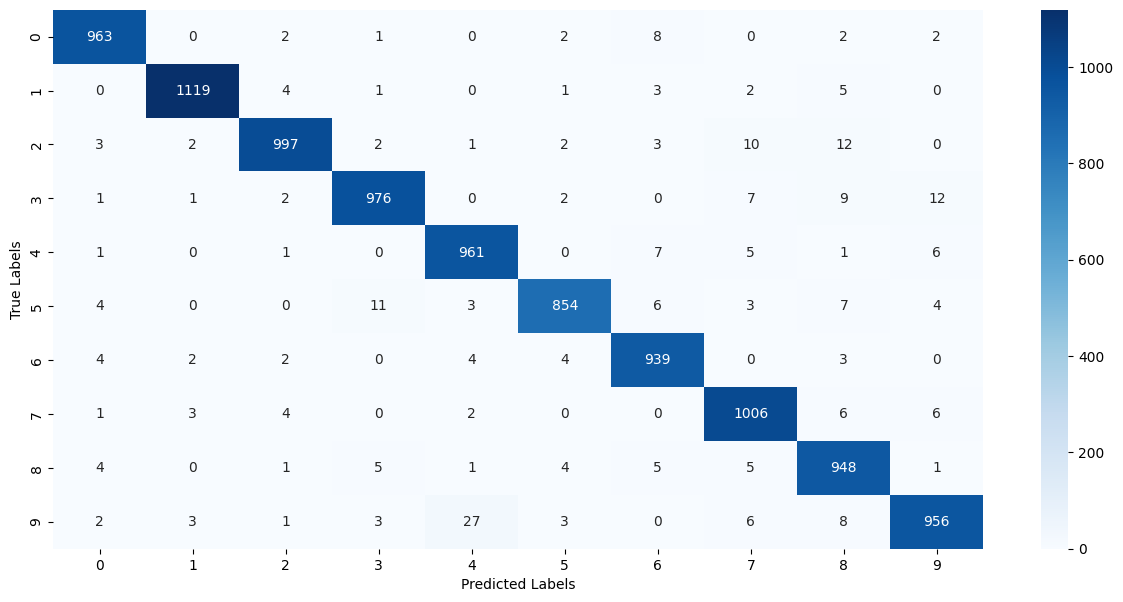

In [ ]:
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)
plt.figure(figsize = (15,7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')